## Инициализация библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from scipy.stats import shapiro, probplot, mannwhitneyu

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

#### Пути к датасетам

In [2]:
DATASET_PATH = 'train.csv'
VALID_DATASET_PATH = 'test.csv'

## Вспомогательные функции

In [3]:
def show_distplot(feature, data, title, figsize):
    """Диаграмма распределения признака со средней, медианой и модой"""
    
    target_mean = round(data[feature].mean(), 2)
    target_median = data[feature].median()
    target_mode = data[feature].mode()[0]

    plt.figure(figsize = figsize)

    sns.distplot(data[feature], bins=70)

    plt.axvline(x=[target_mean], label='target_mean', linestyle=':',linewidth=4, color='red')
    plt.axvline(x=[target_median], label='target_median', linestyle='--', linewidth=4, color='green')
    plt.axvline(x=[target_mode], label='target_mode', linestyle='-.', linewidth=4, color='orange')
    plt.title(title)
    plt.legend()

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """Отчет с метриками модели"""
    
    print('Train\n\n' + classification_report(y_train_true, y_train_pred))
    print('Test\n\n' + classification_report(y_test_true, y_test_pred))
    print('Confusion Matrix\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, y_train, y_test, train_pool, test_pool):
    """Валидация модели, вывод отчетов"""
    
    y_train_pred = model.predict(train_pool)
    y_test_pred = model.predict(test_pool)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

## Загрузка данных

In [6]:
df_train_base = pd.read_csv(DATASET_PATH)
df_valid_base = pd.read_csv(VALID_DATASET_PATH)

## Анализ данных

### Тренировочный датасет

In [7]:
df_train_base.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Целевая переменная: **Credit Default**

### Пропуски

In [8]:
df_train_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Пропуски есть в признаках:
* Annual Income
* Years in current job
* Months since last delinquent
* Credit Score

Пропуски в признаках **Annual Income** и **Credit Score** будем заполнять регрессией

### Числовые признаки

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

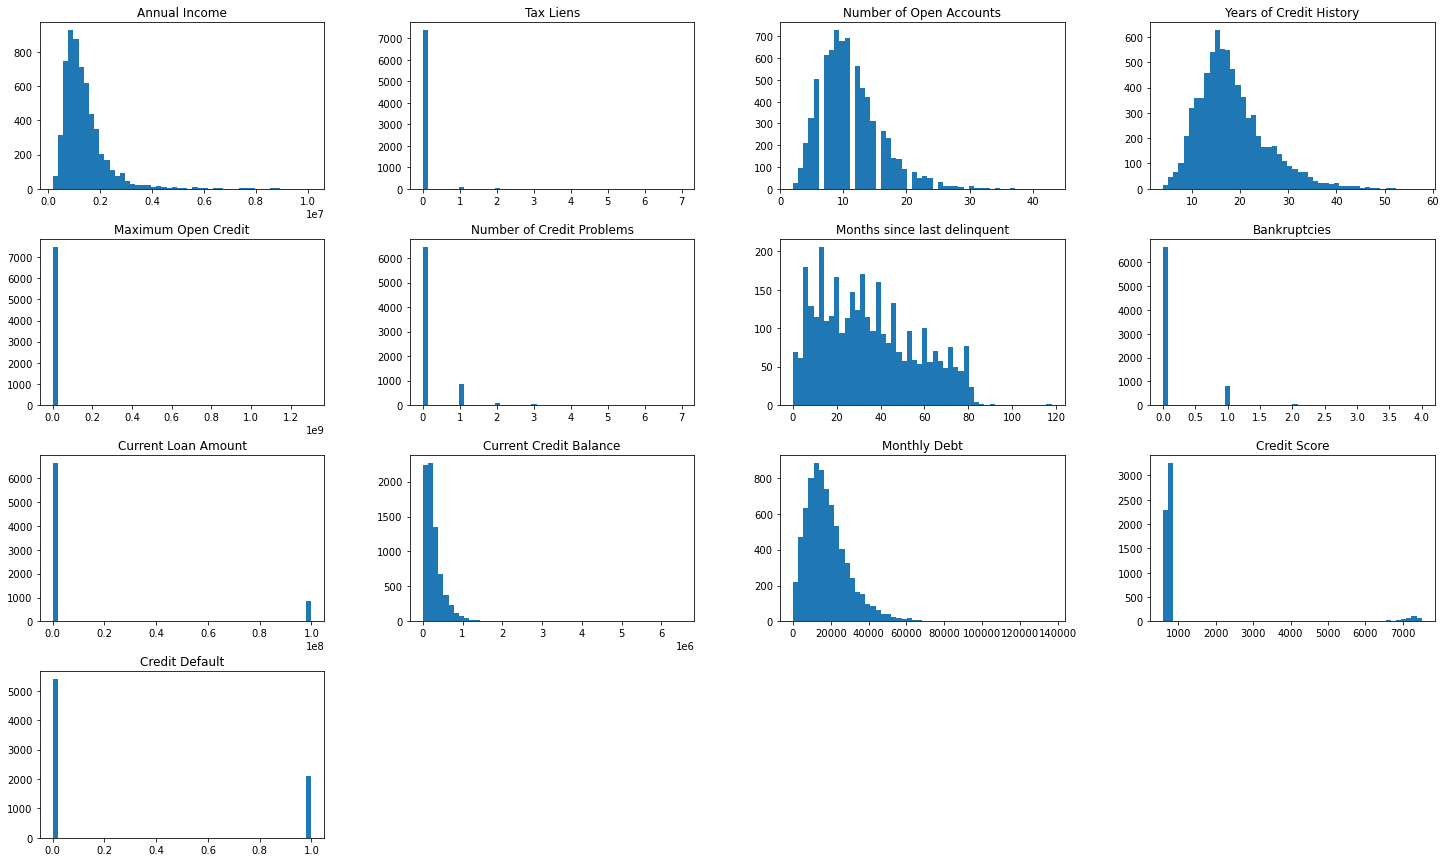

In [9]:
df_train_base.select_dtypes(exclude=['object']).hist(figsize=(25,15), bins=50, grid=False)

Признаки, которые необходимо будет дополнительно рассмотреть на возможность обработки выбросов:
* Credit Score
* Current Credit Balance

### Анализ признаков на выбросы

#### Credit Score

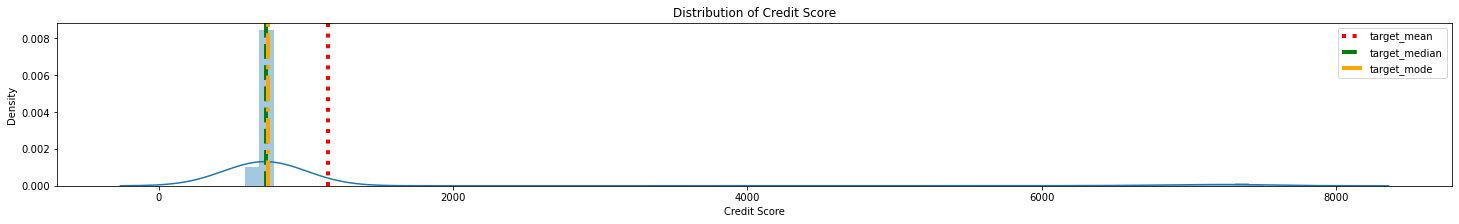

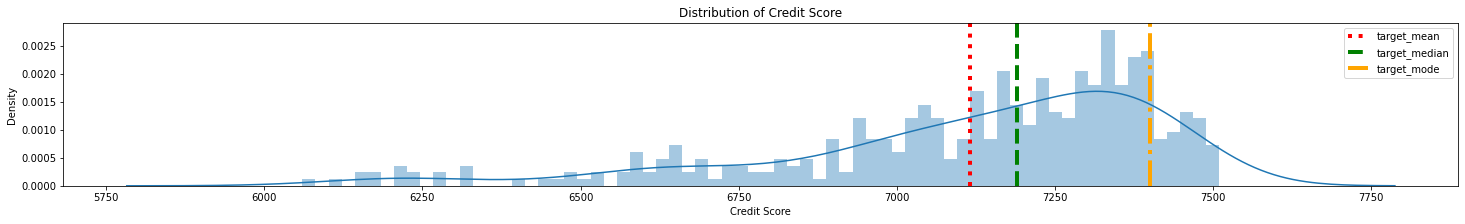

In [10]:
show_distplot(feature='Credit Score', data=df_train_base, title='Distribution of Credit Score', figsize=(25,3))
show_distplot(feature='Credit Score', data=df_train_base[df_train_base['Credit Score'] > 1000], title='Distribution of Credit Score', figsize=(25,3))

Видно, что признак имеет некоторое скопление значений в области от 6000 до 7500. Возможно это ошибочные данные.

Данный принак оставим как есть.

#### Current Credit Balance

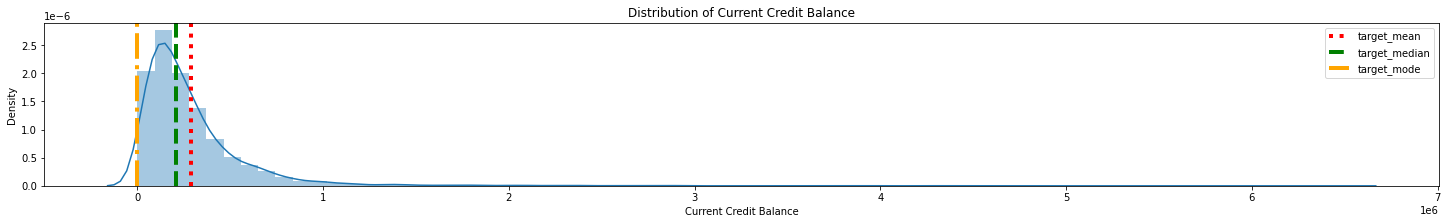

In [11]:
show_distplot(feature='Current Credit Balance', data=df_train_base, title='Distribution of Current Credit Balance', figsize=(25,3))

In [12]:
df_train_base[df_train_base['Current Credit Balance'] > 2000000].shape[0]

41

In [13]:
df_train_base[df_train_base['Current Credit Balance'] > 2000000].head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
93,Home Mortgage,NaN,10+ years,0.0,18.0,17.9,3028014.0,0.0,NaN,0.0,debt consolidation,Short Term,311168.0,2327443.0,55716.0,NaN,0
162,Home Mortgage,2131591.0,< 1 year,0.0,15.0,31.7,4191176.0,0.0,NaN,0.0,debt consolidation,Short Term,269258.0,3547262.0,20783.0,728.0,0
604,Home Mortgage,2822773.0,1 year,0.0,13.0,29.5,3409934.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,2612177.0,50810.0,727.0,0
837,Home Mortgage,5131482.0,2 years,0.0,16.0,20.7,4860504.0,0.0,16.0,0.0,debt consolidation,Short Term,756228.0,2833451.0,44473.0,737.0,0
1211,Own Home,2150477.0,8 years,0.0,31.0,31.3,3866918.0,0.0,NaN,0.0,debt consolidation,Long Term,757834.0,2063875.0,70966.0,722.0,0


Как видно из графика, признак имеет длинный хвост справа, но сами данные не выглядят бесполезно. Оставим как есть.

### Добавление новых признаков

* Current_Loan_Amount_cat: категориальный признак для вещественного Current Loan Amount
* isSusp: будем присваивать 1 наблюдениям с возрастом кредитной истории больше 55 лет и кредитным рейтингом больше 1000

### Заполнение пропусков регрессией

* Annual Income
* Credit Score

Сперва заполняем в этих признаках пропуски медианой (наблюдения с пропусками помечаем отдельным признаком).
Далее делаем для них категориальные признаки. При обучении модели отдаем только наблюдения, в которых не было пропусков, обучаем.
После чего, выбираем помеченные наблюдения, как пропуски, и заполняем значения на основе предсказаний модели.

## Класс с обработкой данных

In [14]:
class Data:

    def __init__(self):
        
        self.medians = None
        self.model_regr_CrSc = None
        self.model_regr_AnIn = None
        
    def fit(self, df):
        
        self.medians = df[['Annual Income', 'Credit Score']].median()
    
    def fit_regr_Credit_Score(self, df):
        """Создание регрессии по Credit Score, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Credit_Score_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Credit_Score_isnan'], axis=1)
        target_name_regr = 'Credit Score'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_CrSc = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=400,
            learning_rate=0.03,
            l2_leaf_reg=2
        )

        self.model_regr_CrSc.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )

        print(f'Credit Score R2: {self.model_regr_CrSc.get_best_score()}')
        del df_regr
        
    def fit_regr_Annual_Income(self, df):
        """Создание регрессии по Annual Income, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Annual_Income_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Annual_Income_isnan'], axis=1)
        target_name_regr = 'Annual Income'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_AnIn = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=6,
            iterations=900,
            learning_rate=0.5,
            l2_leaf_reg=3.5
        )

        self.model_regr_AnIn.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )
        
        print(f'Annual Income R2: {self.model_regr_AnIn.get_best_score()}')
        del df_regr
    
    def apply_regr_Credit_Score(self, df):
        """Заполнение пропусков Credit Score"""
        
        cond = (df['Credit_Score_isnan'] == 1)
        Xc = df[cond].drop(['Credit Score', 'Credit Default', 'Credit_Score_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Credit Score'] = self.model_regr_CrSc.predict(Xc)
        df = df.drop(['Credit_Score_isnan', 'Credit_Score_cat'], axis=1)
        return df

    def apply_regr_Annual_Income(self, df):
        """Заполнение пропусков Annual Income"""
        
        cond = (df['Annual_Income_isnan'] == 1)
        Xc = df[cond].drop(['Annual Income', 'Credit Default', 'Annual_Income_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Annual Income'] = self.model_regr_AnIn.predict(Xc)
        df = df.drop(['Annual_Income_isnan', 'Annual_Income_cat'], axis=1)
        return df
    
    def transform(self, df):
        
        # пропуски
        df['Years in current job'].fillna('nan', inplace=True)
        df['Months since last delinquent'].fillna(0, inplace=True)
        df['Bankruptcies'].fillna(0, inplace=True)
        
        # заполнение Annual Income регрессией
        df['Annual_Income_isnan'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual_Income_isnan'] = 1
        df['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        
        # заполнение Credit Score регрессией
        df['Credit_Score_isnan'] = 0
        df.loc[df['Credit Score'].isna(), 'Credit_Score_isnan'] = 1
        df['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        return df
    
    def features(self, df):
        
        # признак подозрительных наблдений
        df = self.feature_isSusp(df)
        
        # признак с кредитным рейтингом
        # используется при регрессии, далее удаляется
        df = self.credit_score_to_cat(df)
        
        # признак с текущей суммой кредита, разбитой на категории
        df = self.current_loan_amount_to_cat(df)
        
        # признак с годовым доходом, разбитым на категории
        # используется при регрессии, далее удаляется
        df = self.annual_income_to_cat(df)
        
        columns_to_int = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']
        df[columns_to_int] = df[columns_to_int].astype(int)
        
        return df
    
    @staticmethod
    def credit_score_to_cat(df):
        """Создание признака Credit_Score_cat"""
        
        df['Credit_Score_cat'] = np.nan
        
        df.loc[df['Credit Score'] < 600, 'Credit_Score_cat'] = 1
        df.loc[(df['Credit Score'] >= 600) & (df['Credit Score'] < 650), 'Credit_Score_cat'] = 2
        df.loc[(df['Credit Score'] >= 650) & (df['Credit Score'] < 700), 'Credit_Score_cat'] = 3
        df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 725), 'Credit_Score_cat'] = 4
        df.loc[(df['Credit Score'] >= 725) & (df['Credit Score'] < 735), 'Credit_Score_cat'] = 5
        df.loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 745), 'Credit_Score_cat'] = 6
        df.loc[(df['Credit Score'] >= 745) & (df['Credit Score'] < 755), 'Credit_Score_cat'] = 7
        df.loc[df['Credit Score'] >= 755, 'Credit_Score_cat'] = 8
        
        df['Credit_Score_cat'] = df['Credit_Score_cat'].astype(int)
        
        return df
    
    @staticmethod
    def current_loan_amount_to_cat(df):
        """Создание признака Current_Loan_Amount_cat"""
        
        df['Current_Loan_Amount_cat'] = np.nan
        
        df.loc[df['Current Loan Amount'] < 100000, 'Current_Loan_Amount_cat'] = 1
        df.loc[(df['Current Loan Amount'] >= 100000) & (df['Current Loan Amount'] < 150000), 'Current_Loan_Amount_cat'] = 2
        df.loc[(df['Current Loan Amount'] >= 150000) & (df['Current Loan Amount'] < 250000), 'Current_Loan_Amount_cat'] = 3
        df.loc[(df['Current Loan Amount'] >= 250000) & (df['Current Loan Amount'] < 300000), 'Current_Loan_Amount_cat'] = 4
        df.loc[(df['Current Loan Amount'] >= 300000) & (df['Current Loan Amount'] < 325000), 'Current_Loan_Amount_cat'] = 5
        df.loc[(df['Current Loan Amount'] >= 325000) & (df['Current Loan Amount'] < 350000), 'Current_Loan_Amount_cat'] = 6
        df.loc[(df['Current Loan Amount'] >= 350000) & (df['Current Loan Amount'] < 400000), 'Current_Loan_Amount_cat'] = 7
        df.loc[(df['Current Loan Amount'] >= 400000) & (df['Current Loan Amount'] < 450000), 'Current_Loan_Amount_cat'] = 8
        df.loc[(df['Current Loan Amount'] >= 450000) & (df['Current Loan Amount'] < 500000), 'Current_Loan_Amount_cat'] = 9
        df.loc[df['Current Loan Amount'] >= 500000, 'Current_Loan_Amount_cat'] = 10
        
        df['Current_Loan_Amount_cat'] = df['Current_Loan_Amount_cat'].astype(int)
        
        return df

    @staticmethod
    def annual_income_to_cat(df):
        """Создание признака Annual_Income_cat"""
        
        df['Annual_Income_cat'] = np.nan
        
        df.loc[df['Annual Income'] < 500000, 'Annual_Income_cat'] = 1
        df.loc[(df['Annual Income'] >= 500000) & (df['Annual Income'] < 750000), 'Annual_Income_cat'] = 2
        df.loc[(df['Annual Income'] >= 750000) & (df['Annual Income'] < 1000000), 'Annual_Income_cat'] = 3
        df.loc[(df['Annual Income'] >= 1000000) & (df['Annual Income'] < 1125000), 'Annual_Income_cat'] = 4
        df.loc[(df['Annual Income'] >= 1125000) & (df['Annual Income'] < 1250000), 'Annual_Income_cat'] = 5
        df.loc[(df['Annual Income'] >= 1250000) & (df['Annual Income'] < 1500000), 'Annual_Income_cat'] = 6
        df.loc[(df['Annual Income'] >= 1500000) & (df['Annual Income'] < 1750000), 'Annual_Income_cat'] = 7
        df.loc[(df['Annual Income'] >= 1750000) & (df['Annual Income'] < 2000000), 'Annual_Income_cat'] = 8
        df.loc[(df['Annual Income'] >= 2000000) & (df['Annual Income'] < 2500000), 'Annual_Income_cat'] = 9
        df.loc[df['Annual Income'] >= 2500000, 'Annual_Income_cat'] = 10
        
        df['Annual_Income_cat'] = df['Annual_Income_cat'].astype(int)
        
        return df
    
    @staticmethod
    def feature_isSusp(df):
        """Признак подозрительных наблюдений"""
        
        df['isSusp'] = 0
        df.loc[df['Years of Credit History'] > 55, 'isSusp'] = 1
        df.loc[df['Credit Score'] > 1000, 'isSusp'] = 1
        
        return df

## Инициализация класса

In [15]:
df_train_base = pd.read_csv(DATASET_PATH)
df_valid_base = pd.read_csv(VALID_DATASET_PATH)

data_inst = Data()

# тренировочный датасет
data_inst.fit(df_train_base)
df_train = data_inst.transform(df_train_base)
df_train = data_inst.features(df_train)

# регрессия Credit Score
data_inst.fit_regr_Credit_Score(df_train)
df_train = data_inst.apply_regr_Credit_Score(df_train)

# регрессия Annual Income
data_inst.fit_regr_Annual_Income(df_train)
df_train = data_inst.apply_regr_Annual_Income(df_train)

# тестовый датасет
df_valid = data_inst.transform(df_valid_base)
df_valid = data_inst.features(df_valid)
df_valid = data_inst.apply_regr_Credit_Score(df_valid)
df_valid = data_inst.apply_regr_Annual_Income(df_valid)

target_name = 'Credit Default'
feature_names = df_train.columns.drop(target_name).tolist()
feature_names_num = df_train.select_dtypes(include='float64').columns.tolist()
feature_names_cat = df_train.select_dtypes(include=['int64', 'object']).columns.drop(target_name).tolist()

Credit Score R2: {'learn': {'R2': 0.998345914489616, 'RMSE': 66.77692030178164}, 'validation': {'R2': 0.99801413564596, 'RMSE': 67.37174903154758}}
Annual Income R2: {'learn': {'R2': 0.9239655949050914, 'RMSE': 228917.7880191751}, 'validation': {'R2': 0.8373878567502362, 'RMSE': 354633.11758766376}}


## Корреляция признаков с целевой переменной

Text(0.5, 1.0, 'Correlation with target variable')

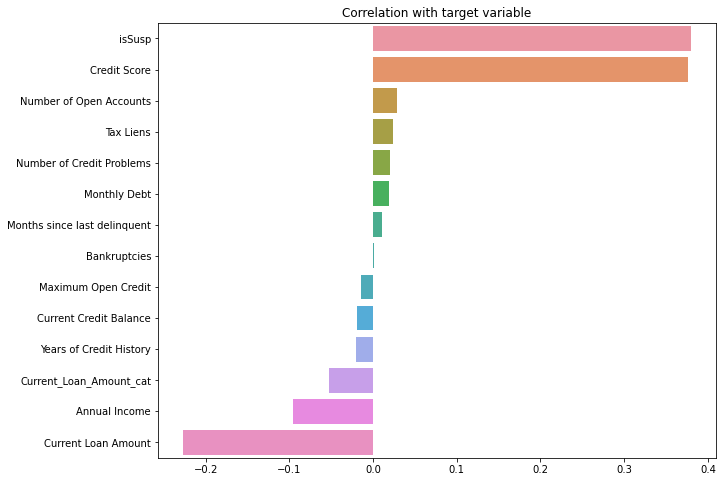

In [16]:
corr_with_target = df_train[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

Интересующий признак: **Credit Score**

### Корреляция признака Credit Score с целевой переменной в разрезе классов

Text(0.5, 1.0, 'Credit Score grouped by target variable')

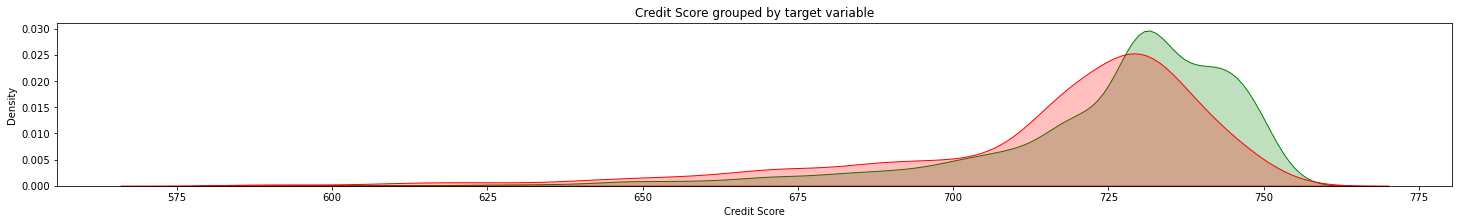

In [17]:
credit_score_with_target = df_train[df_train['Credit Score'] < 1000][['Credit Score', target_name]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[target_name] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[target_name] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(credit_score_target_0, shade=True, label='class 0', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='class 1', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')

### Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [18]:
shapiro(credit_score)

ShapiroResult(statistic=0.82184898853302, pvalue=0.0)

Значение p-value меньше 0.05, следовательно распределение отлично от "нормального"

((array([-3.72509304, -3.49508022, -3.36856895, ...,  3.36856895,
          3.49508022,  3.72509304]),
  array([585., 586., 588., ..., 751., 751., 751.])),
 (22.422754836390528, 722.2506025741355, 0.9065532145807904))

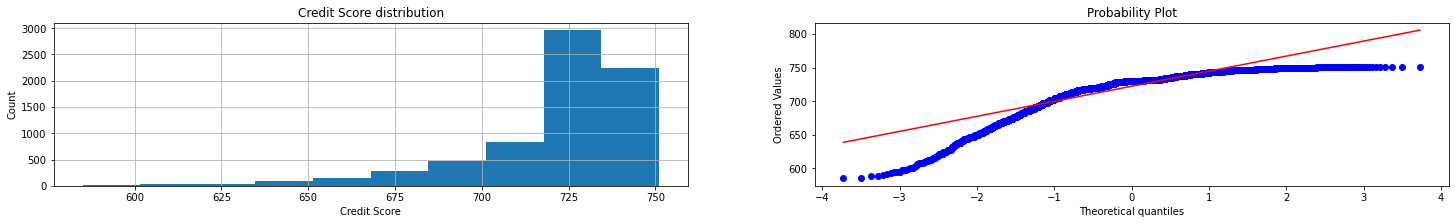

In [19]:
plt.figure(figsize=(25, 3))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score.hist()

plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

Графическое представление подтверждает, что распределение отлично от "нормального"

### Оценка эквивалентности математических ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [20]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=3444824.0, pvalue=1.0844079762547325e-56)

Значение p-value меньше 0.05, следовательно гипотеза о равности математических ожиданий отвергается

Text(0.5, 1.0, 'Confidence intervals (95 %) for Credit Score')

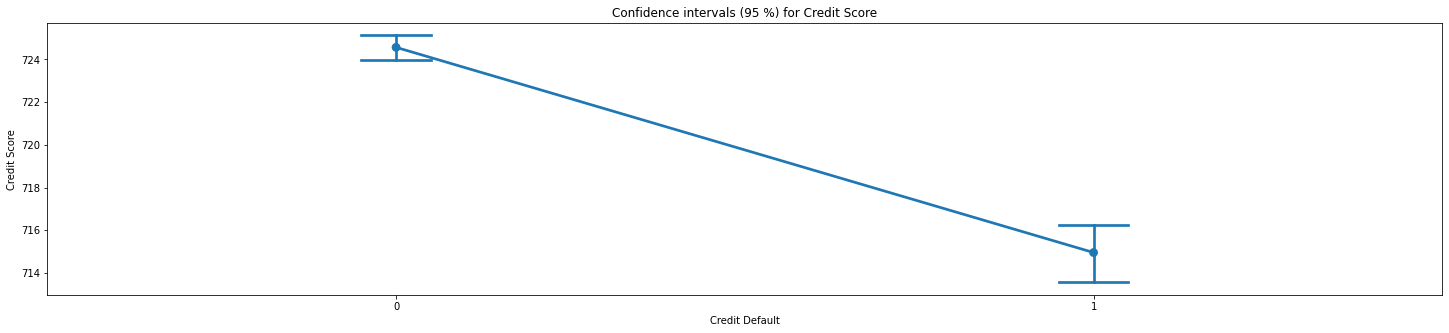

In [21]:
plt.figure(figsize=(25, 5))

sns.pointplot(x=target_name, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')

Математические ожидания не пересекаются. Признак будет полезен.

### Матрица корреляций

Text(0.5, 1.0, 'Correlation matrix')

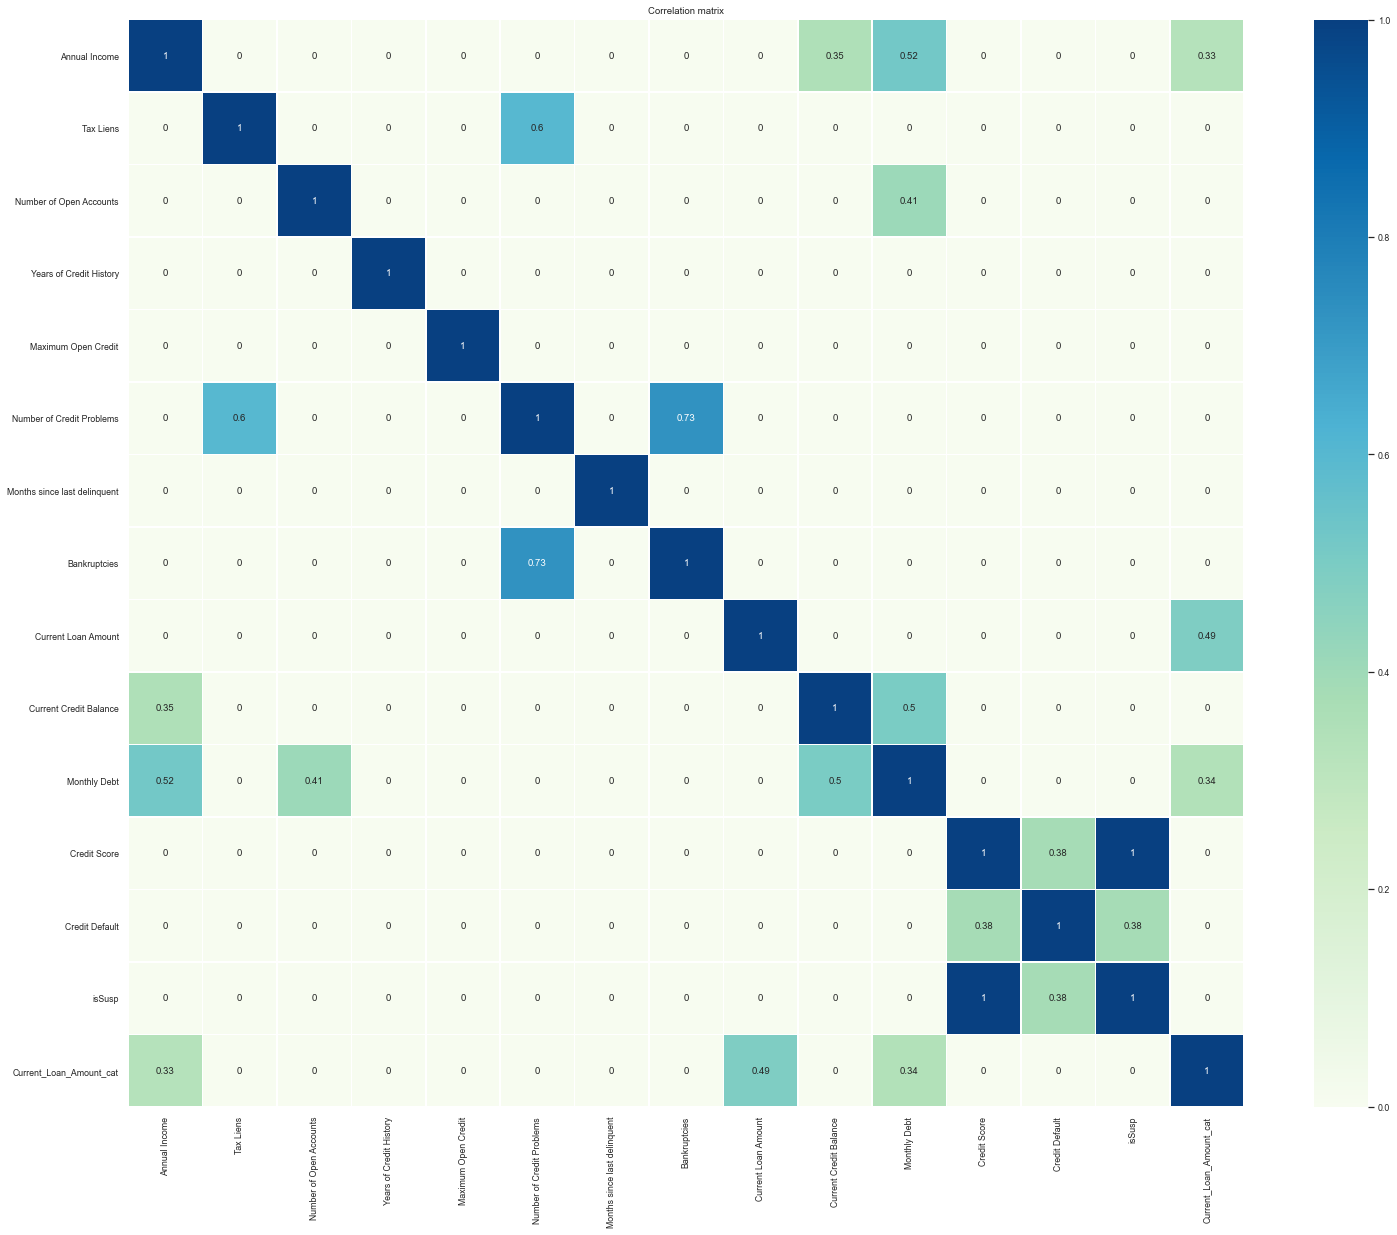

In [22]:
plt.figure(figsize = (25,20))

sns.set(font_scale=0.8)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')

## Разбиение обучающего датасета на train и test

In [23]:
X = df_train[feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### Проверка распределения вещественных признаков на X_train и X_test

Annual Income: 0.044
Number of Open Accounts: 0.303
Years of Credit History: 0.379
Maximum Open Credit: 0.452
Months since last delinquent: 0.311
Current Loan Amount: 0.119
Current Credit Balance: 0.382
Monthly Debt: 0.05
Credit Score: 0.286


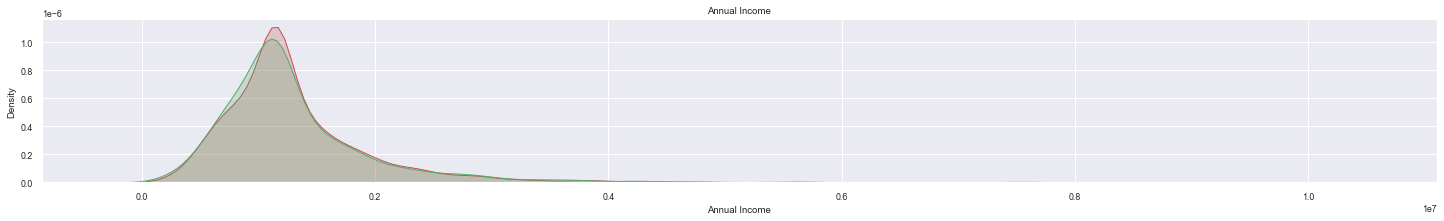

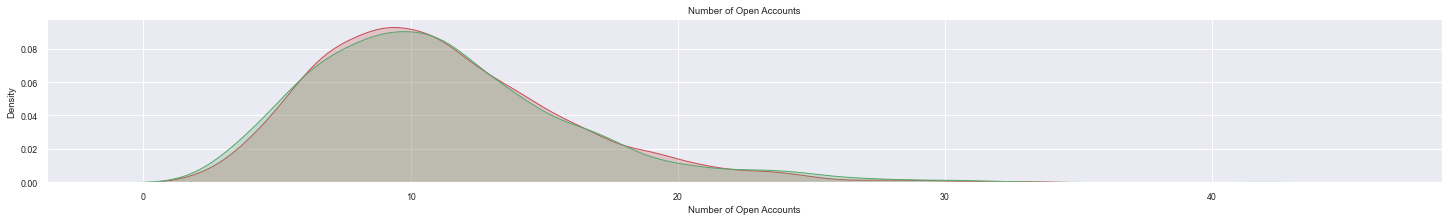

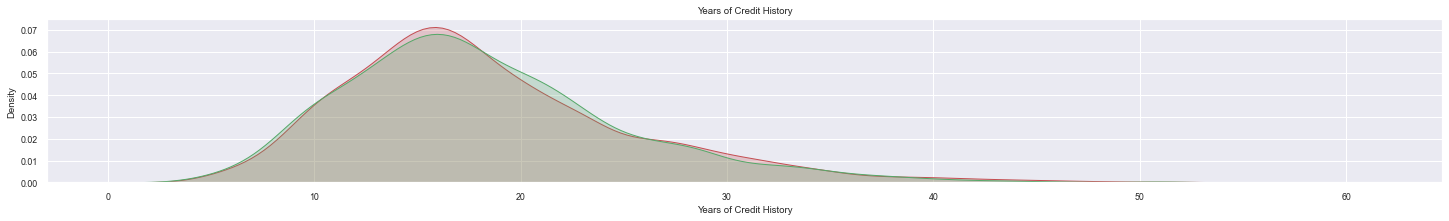

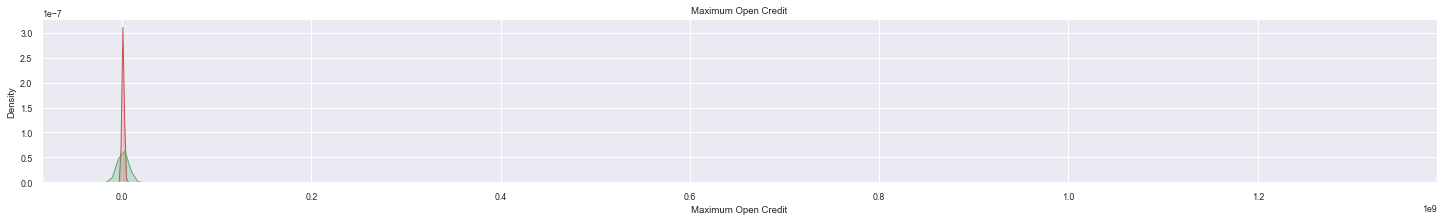

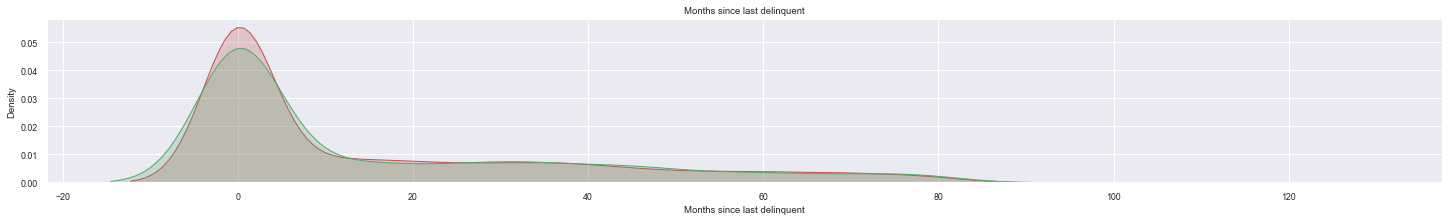

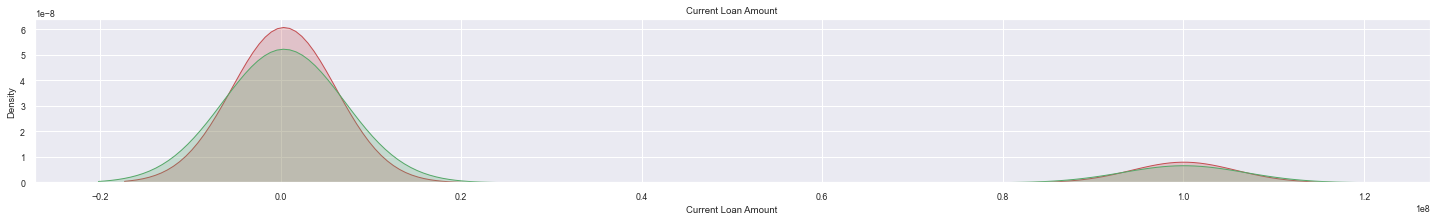

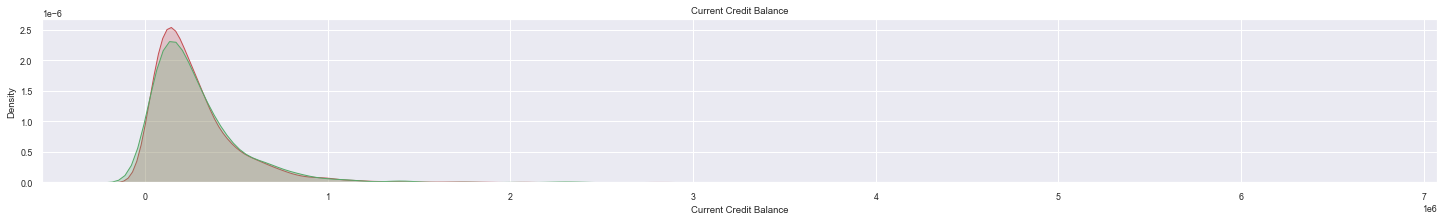

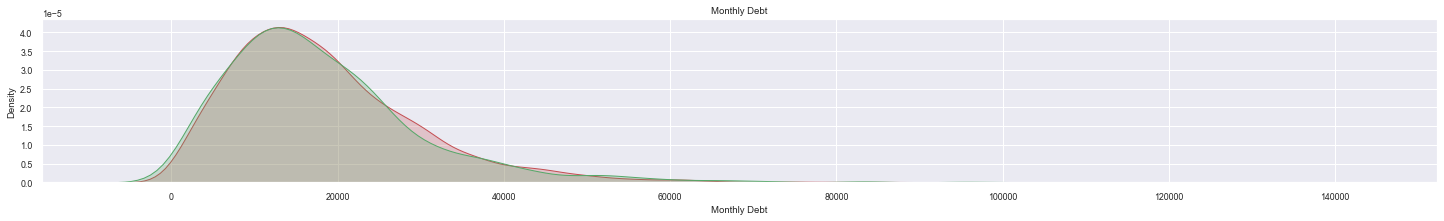

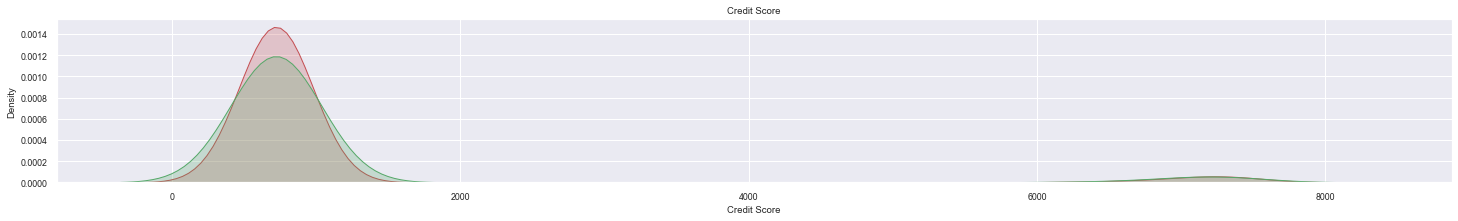

In [24]:
for col in feature_names_num:
    print(col + ': ' + str(round(mannwhitneyu(X_train[col], X_test[col])[1], 3)))
    plt.figure(figsize=(25, 3))
    sns.set(font_scale=0.8)
    sns.kdeplot(X_train[col], shade=True, label='train', color='r')
    sns.kdeplot(X_test[col], shade=True, label='test', color='g')
    plt.title(col)

### Проверка распределения категориальных признаков на X_train и X_test

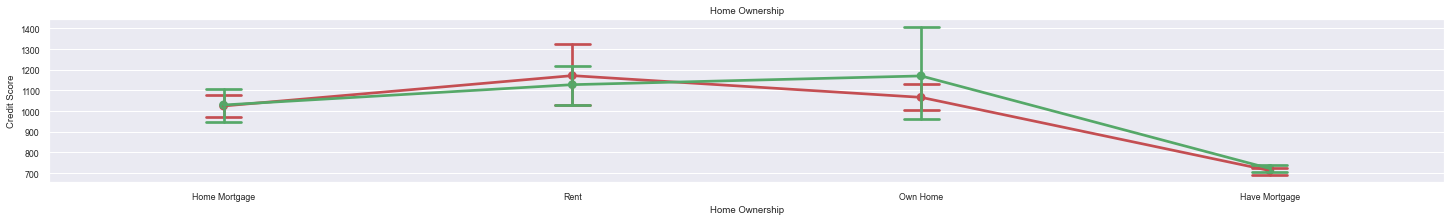

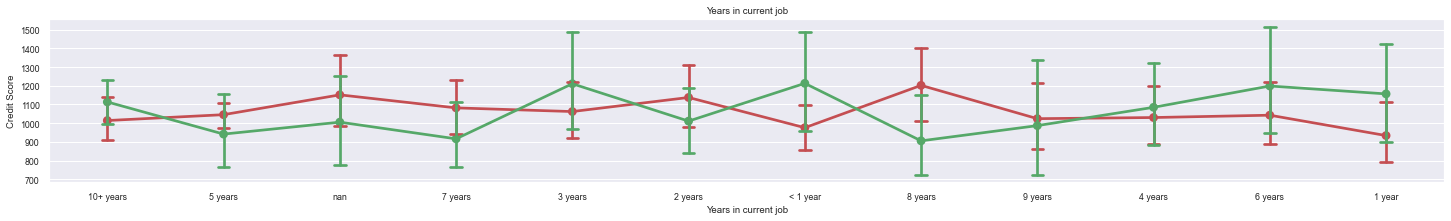

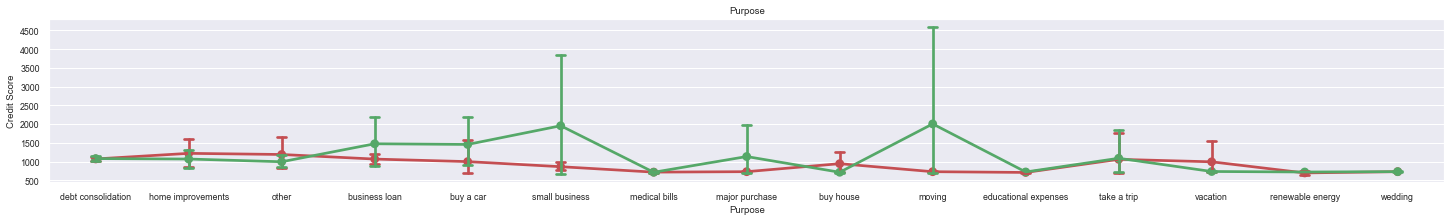

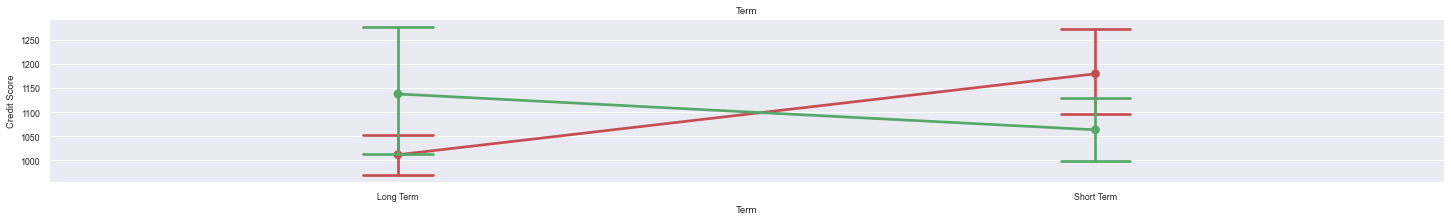

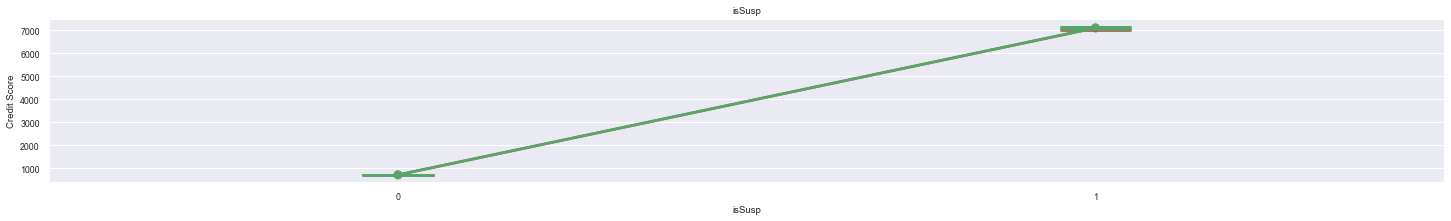

In [25]:
num_feature = 'Credit Score'
for col in feature_names_cat:
    plt.figure(figsize=(25, 3))
    sns.pointplot(x=col, y=num_feature, data=X_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=X_test, capsize=.1, label='test', color='g')
    plt.title(col)

## Обучение модели

### Определение максимального количества уникальных значений среди категориальных признаков

In [26]:
sorted([X_train[feature_names_cat][col].nunique() for col in feature_names_cat])[-1]

15

Возьмем с запасом - 20

### Определение гиперпараметров

Константные параметры:
* eval_metric='F1' метрика
* auto_class_weights='Balanced' автоматический подбор весов для балансировки классов
* silent=True блокирование лишнего вывода логов
* cat_features=feature_names_cat категориальные признаки
* one_hot_max_size=20 - определяли выше
* early_stopping_rounds=50 - отслеживание переобучения
* boosting_type='Ordered' - дает лучше результат на небольших датасетах

Подбираемые параметры:
* depth
* learning_rate
* iterations
* bagging_temperature

In [27]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=feature_names_cat
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=feature_names_cat
) 

params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

### Код определения гиперпараметров

    %%time

    cbr_model = CatBoostClassifier(**params_model)

    params_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'iterations': [100, 200, 400],
        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
        'bagging_temperature': [1, 1.5, 2]
    }

    gs = cbr_model.randomized_search(
        params_grid,
        train_pool,
        n_iter=20,
        shuffle=True,
        stratified=True,
        partition_random_seed=42,
        cv=5
    )

    # pd.DataFrame(gs['cv_results']).sort_values('test-F1-mean', ascending=False).head()
    gs

## Обучение финальной модели

### Подобранные гиперпараметры

    depth=6,
    iterations=100,
    learning_rate=0.5,
    l2_leaf_reg=3.5,
    bagging_temperature=1.5

### Обучение с подобранными гиперпараметрами

In [28]:
%%time

cbr_final_model = CatBoostClassifier(
    **params_model,
    depth=6,
    iterations=100,
    learning_rate=0.5,
    l2_leaf_reg=3.5,
    bagging_temperature=1.5
)

cbr_final_model.fit(train_pool, eval_set=test_pool)

Wall time: 684 ms


### Результаты

In [29]:
evaluate_preds(cbr_final_model, y_train, y_test, train_pool, test_pool)

Train

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      3771
           1       0.52      0.71      0.60      1479

    accuracy                           0.73      5250
   macro avg       0.69      0.73      0.70      5250
weighted avg       0.77      0.73      0.74      5250

Test

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1616
           1       0.48      0.66      0.56       634

    accuracy                           0.71      2250
   macro avg       0.66      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

Confusion Matrix

col_0              0    1
Credit Default           
0               1173  443
1                218  416


### Веса признаков

In [30]:
feature_importances = pd.DataFrame(
    zip(X.columns, cbr_final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
16,isSusp,30.263630
12,Current Loan Amount,27.604599
11,Term,8.779707
1,Annual Income,7.413952
15,Credit Score,7.160475
13,Current Credit Balance,3.270495
14,Monthly Debt,3.263697
6,Maximum Open Credit,3.234024
17,Current_Loan_Amount_cat,2.039970
5,Years of Credit History,1.626242


### Сохранение результатов предсказаний финальной модели

In [31]:
y_test_pred = cbr_final_model.predict(df_valid)

preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': np.arange(0,y_test_pred.shape[0]), 'Credit Default': y_test_pred})
preds_final.to_csv('./Credit_default_prediction1.csv', index=False, encoding='utf-8', sep=',')
preds_final.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,1
7,7,1
8,8,0
9,9,0
